In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import csv
from datetime import datetime
import numpy as np
from scipy import signal

# Obtain US Covid Data 
Johns Hopkins University data on Covid from Kaggle: 
https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university

Download `CONVENIENT_us_confirmed_cases.csv`.

In [2]:
# Read csv file
with open('CONVENIENT_us_confirmed_cases.csv') as f:
    c = csv.reader(f)
    states = next(c)[1:]
    county = next(c)[1:]
    rows = [line for line in c]
    dates = [datetime.strptime(row[0],'%m/%d/%y').date() for row in rows]
    cases = np.array([[float(f) for f in line[1:]] for line in rows])

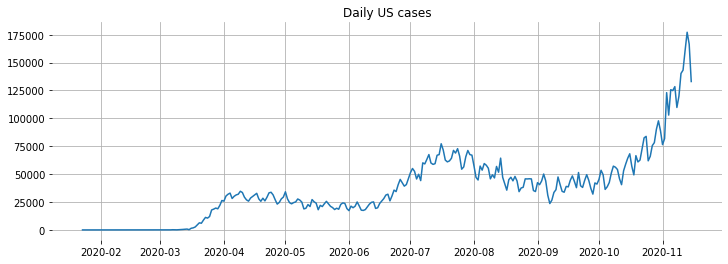

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(dates, cases.sum(axis=1))
ax.set_title('Daily US cases')
ax.grid(True)
ax.set_frame_on(False)

In [4]:
# downsample per week 
X = signal.decimate(cases, 7, axis=0)*7
t = dates[2::7]

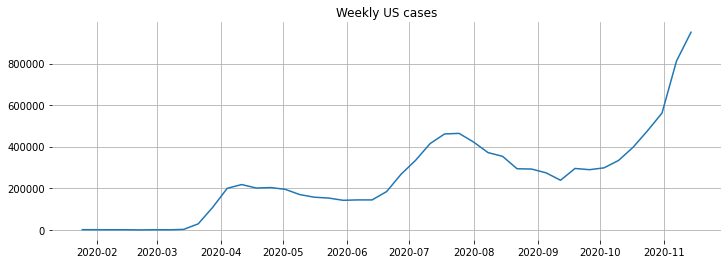

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(t, X.sum(axis=1))
ax.set_title('Weekly US cases')
ax.grid(True)
ax.set_frame_on(False)

In [6]:
# average by state
from collections import defaultdict
totals = defaultdict(int)
for s, x in zip(states, X.T):
    totals[s] += x

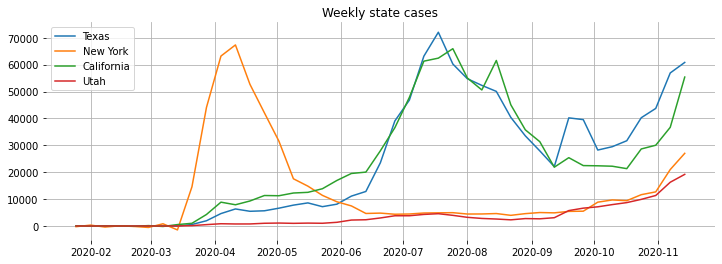

In [7]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
select = ('Texas', 'New York', 'California', 'Utah')
for state in select:
    ax.plot(t, totals[state])
ax.set_title('Weekly state cases')
ax.legend(select)
ax.set_frame_on(False)
ax.grid(True)

# PCA by SVD

Singular value decomposition decomposes rectangular matrix $X$ into three components.

$$X = U D V^T$$


where $U$ and $V$ are orthonormal, so that $U^TU=I$ and $V^TV=I$ and $D$ is diagonal with descending positive magnitudes (singular values).

Therefore

$$X V = U D V^T V = U D I = U D$$ 

$$U^T X = U^T U D V^T = I D V^T = D V^T$$


This is a very useful decomposition that simplifies many matrix operations. 

$X$ has dimensions $\text{states} \times \text{weeks}$.

Therefore, $U^T X$ will contain the principal components, ordered by significance, in the space of weeks, and $X V$ will contain the principal components in the space of states. 

Dimensionality reduction is achieved by plotting the first few of these principal components.

In [8]:
# perform singular value decomposition
X = np.array(list(totals.values()))
# a rule for scaling states by size to make smaller states more significant
X /= np.sqrt(100 + X.sum(axis=-1, keepdims=True)) 
U, D, V = np.linalg.svd(X, full_matrices=False)
V = V.T  # since svd returns the transpose

# Principal components in time

We plot the first few columns of $U^T X$, which will have the dimension of time. This shows the few modes of evolution of Covid infections across all states. In each state, the pandemic developed as a weighted some of these components.

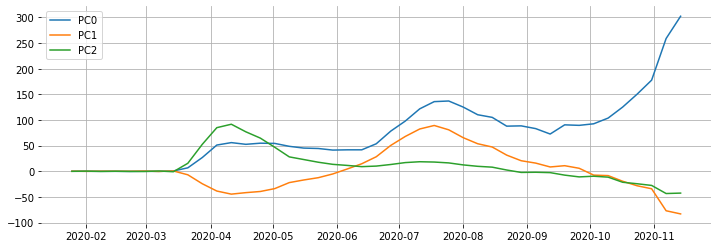

In [9]:
# plot first 3 principal comonents for time:
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(t, (U.T @ X)[:3, :].T)
ax.grid(True)
ax.set_frame_on(False)
ax.legend(("PC0", "PC1", "PC2", "PC3"))

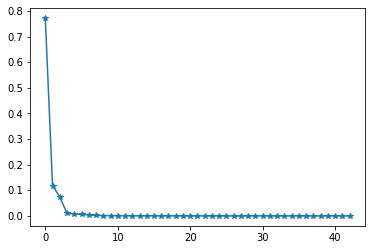

In [10]:
plt.plot(D**2 / (D**2).sum(), '*-')

# Principal components across states

Then we plot the first few columns of $X V$, which will have the dimension of states. This shows how states cluster in the space defined by the temporal principal components above. States that are close together followed a similar evolution infection rates.

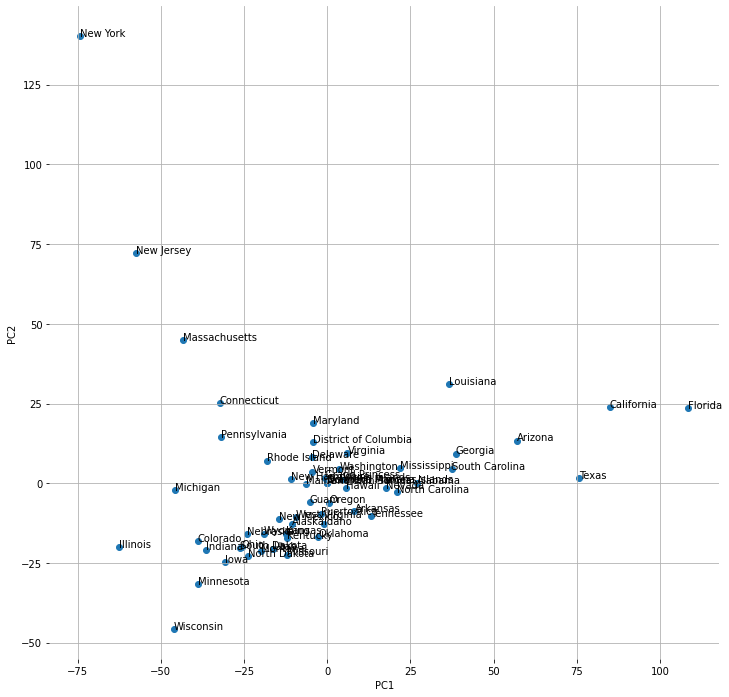

In [11]:
# plot states on principle components
c1, c2 = 1, 2
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
W = X @ V   # W = U @ np.diag(D)
ax.scatter(W[:, c1], W[:, c2])
for i, (name, u) in enumerate(zip(totals, W)):
    ax.annotate(name, (u[c1], u[c2]))
ax.grid(True)
ax.set_xlabel(f"PC{c1}")
ax.set_ylabel(f"PC{c2}")
ax.set_frame_on(False)
fig.savefig('states.png', dpi=75)

# PCA through the Eigenvalue decomposition of the sample covariance matrix.

$X$ dimensions = states $\times$ weeks.

Sample covariance between states $\text{cov}_{states} = X X^T / n_{weeks}$   (states $\times$ states)

Sample covariance between weeks $\text{cov}_{weeks} = X^T X / n_{states}$   (weeks $\times$ weeks)

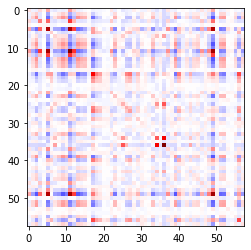

In [12]:
# State covariance matrix
Y = X - X.mean(axis=0, keepdims=True)
C = Y @ Y.T
vmax = abs(C).max()
plt.imshow(C, vmin=-vmax, vmax=vmax, cmap='seismic')

In [13]:
D, U = np.linalg.eig(C)  #  PCA 

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


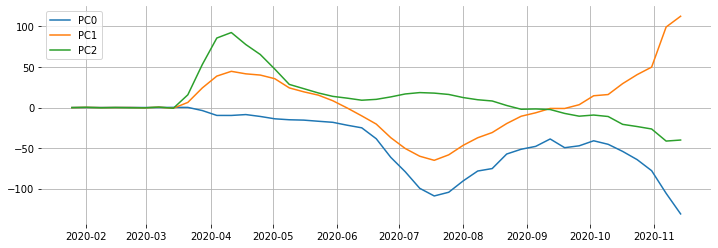

In [20]:
# plot first 3 principal comonents for time:
fig, ax = plt.subplots(1,1, figsize=(12,4))
principal_components = (U.T @ X)
ax.plot(t, principal_components[:3, :].T)
ax.grid(True)
ax.set_frame_on(False)
ax.legend(("PC0", "PC1", "PC2", "PC3"))

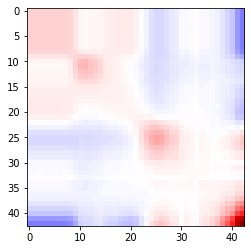

In [15]:
# Time covariance 

Y = X - X.mean(axis=1, keepdims=True)
C = Y.T @ Y
vmax = abs(C).max()
plt.imshow(C, vmin=-vmax, vmax=vmax, cmap='seismic')

In [16]:
D, V = np.linalg.eig(C)  #  PCA 

In [18]:
V.shape

(43, 43)

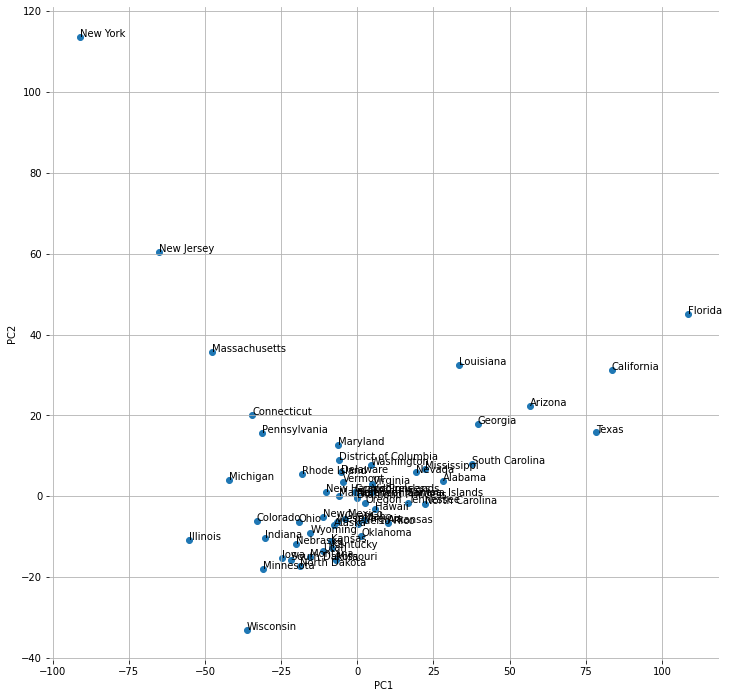

In [19]:
# plot states on principle components
c1, c2 = 1, 2
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
W = X @ V   # W = U @ np.diag(D)
ax.scatter(W[:, c1], W[:, c2])
for i, (name, u) in enumerate(zip(totals, W)):
    ax.annotate(name, (u[c1], u[c2]))
ax.grid(True)
ax.set_xlabel(f"PC{c1}")
ax.set_ylabel(f"PC{c2}")
ax.set_frame_on(False)
fig.savefig('states.png', dpi=75)

# Project  
### Due Dec 7

**Data:** Boyer, Rick, and David Savageau. Places rated almanac: Your guide to finding the best places to live in America. Rand McNally & Company, 1985.

PCA Lesson: https://online.stat.psu.edu/stat505/lesson/11

Data: http://www.stat.nthu.edu.tw/~swcheng/Teaching/stat5191/assignment/places.txt

1. Normalize the data (apply log, subtract mean, normalize std dev) 
2. Perform PCA (use SVD or the eigenvalue decomposition of the covariance matrix)
3. Plot the Scree plot. How much variance is explained by the first three PCs?
4. Scatter plot all communities along two of the PCs (PC0 vs PC1 or PC1 vs PC2)
5. Scatter plot all original dimensions in the space of PC0 and PC1. 
6. Do something interesting as you like.